In [299]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torchvision.transforms import transforms
from PIL import Image
import pandas as pd
import random
from torch import optim
from torch.optim import lr_scheduler
import copy
import torch.nn as nn
import torch.nn.functional as F

In [300]:
 
class Net(nn.Module):
    # # define __init__ function
    def __init__(self):
        # ## call __init__ function from super class
        super(Net, self).__init__()
        # ## define net structure
        self.conv1 = nn.Conv2d(3, 3, 3)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(3, 6, 3)
        self.bn2 = nn.BatchNorm2d(6)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(6, 12, 3)
        self.bn3 = nn.BatchNorm2d(12)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(12 * 60 * 60, 150)
        self.relu4 = nn.ReLU(inplace=True)

        self.drop = nn.Dropout2d()

        self.fc2_1 = nn.Linear(150, 2)
        self.softmax_1 = nn.Softmax(dim=1)

        self.fc2_2 = nn.Linear(150, 3)
        self.softmax_2 = nn.Softmax(dim=1)

    # # define forward function
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(-1, 12 * 60 * 60)
        x = self.fc1(x)
        x = self.relu4(x)

        x = F.dropout(x, training=self.training)

        x_classes = self.fc2_1(x)
        x_classes = self.softmax_1(x_classes)

        x_species = self.fc2_2(x)
        x_species = self.softmax_2(x_species)

        return x_classes, x_species


In [301]:
ROOT_DIR = '../Dataset/'
TRAIN_DIR = 'train/'
VAL_DIR = 'val/'
TRAIN_ANNO = 'Multi_train_annotation.csv'
VAL_ANNO = 'Multi_val_annotation.csv'
CLASSES = ['birds', 'mammals']
SPECIES = ['chickens', 'rabbits', 'rats']

In [302]:
class MyDataset():

    def __init__(self, root_dir, annotations_file, transform=None):

        self.root_dir = root_dir
        self.annotations_file = annotations_file
        self.transform = transform

        if not os.path.isfile(self.annotations_file):
            print(self.annotations_file + 'does not exist!')
        self.file_info = pd.read_csv(annotations_file, index_col=0)
        self.size = len(self.file_info)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        image_path = self.file_info['path'][idx]
        if not os.path.isfile(image_path):
            print(image_path + '  does not exist!')
            return None

        image = Image.open(image_path).convert('RGB')
        label_class = int(self.file_info.iloc[idx]['classes'])
        label_species = int(self.file_info.iloc[idx]['species'])

        sample = {'image': image, 'classes': label_class, 'species': label_species}
        if self.transform:
            sample['image'] = self.transform(image)
        return sample

In [303]:
train_transforms = transforms.Compose([transforms.Resize((500, 500)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                       ])

In [304]:
val_transforms = transforms.Compose([transforms.Resize((500, 500)),
                                     transforms.ToTensor()
                                     ])

In [305]:
train_dataset = MyDataset(root_dir= ROOT_DIR + TRAIN_DIR,
                          annotations_file= TRAIN_ANNO,
                          transform=train_transforms)

In [306]:
test_dataset = MyDataset(root_dir= ROOT_DIR + VAL_DIR,
                         annotations_file= VAL_ANNO,
                         transform=val_transforms)

In [307]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset)
data_loaders = {'train': train_loader, 'val': test_loader}

In [308]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


543 torch.Size([3, 500, 500]) mammals rabbits


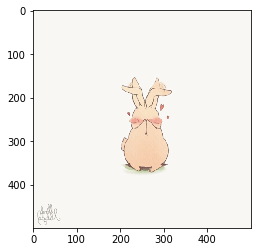

In [309]:
def visualize_dataset():
    #print(len(train_dataset))
    idx = random.randint(0, len(train_dataset))
    sample = train_loader.dataset[idx]
    print(idx, sample['image'].shape, CLASSES[sample['classes']], SPECIES[sample['species']])
    img = sample['image']
    plt.imshow(transforms.ToPILImage()(img))
    plt.show()
visualize_dataset()

In [310]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    Loss_list = {'train': [], 'val': []}
    Accuracy_list_classes = {'train': [], 'val': []}
    Accuracy_list_species = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-*' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects_classes = 0
            corrects_species = 0
            #corrects = 0

            for idx, data in enumerate(data_loaders[phase]):
                inputs = data['image'].to(device)
                labels_classes = data['classes'].to(device)
                labels_species = data['species'].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    x_classes, x_species = model(inputs)
                    x_classes = x_classes.view(-1, 2)
                    _, preds_classes = torch.max(x_classes, 1)
                    x_species = x_species.view(-1, 3)
                    _, preds_species = torch.max(x_species, 1)
                    loss_classes = criterion(x_classes, labels_classes)
                    loss_species = criterion(x_species, labels_species)
                    loss = loss_classes * 0.6 + loss_species * 0.4
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects_classes += torch.sum(preds_classes == labels_classes)
                corrects_species += torch.sum(preds_species == labels_species)
                #corrects += torch.sum((preds_classes == labels_classes) * (preds_species == labels_species))
            
            #if phase == 'train':
            #    scheduler.step()
            
            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            Loss_list[phase].append(epoch_loss)

            epoch_acc_classes = corrects_classes.double() / len(data_loaders[phase].dataset)
            epoch_acc_species = corrects_species.double() / len(data_loaders[phase].dataset)
            #epoch_acc = corrects.double() / len(data_loaders[phase].dataset)
            epoch_acc = epoch_acc_classes / 2 + epoch_acc_species / 2

            Accuracy_list_classes[phase].append(100 * epoch_acc_classes)
            Accuracy_list_species[phase].append(100 * epoch_acc_species)
            print('{} Loss: {:.4f}  Acc_classes: {:.2%} Acc_species: {:.2%}'.format(phase, epoch_loss, epoch_acc_classes, epoch_acc_species))

            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best val Acc: {:.2%}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_model.pt')
    print('Best val Acc: {:.2%}'.format(best_acc))
    return model, Loss_list, Accuracy_list_classes, Accuracy_list_species

In [311]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
model, Loss_list, Accuracy_list_classes, Accuracy_list_species= train_model(network, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 1/50
-*-*-*-*-*-*-*-*-*-*
train Loss: 0.8381  Acc_classes: 59.89% Acc_species: 35.62%
val Loss: 0.8383  Acc_classes: 62.50% Acc_species: 37.50%
Best val Acc: 50.00%
Epoch 2/50
-*-*-*-*-*-*-*-*-*-*
train Loss: 0.7880  Acc_classes: 67.42% Acc_species: 44.61%
val Loss: 0.8481  Acc_classes: 62.50% Acc_species: 37.50%
Epoch 3/50
-*-*-*-*-*-*-*-*-*-*
train Loss: 0.7448  Acc_classes: 73.03% Acc_species: 52.02%
val Loss: 0.8569  Acc_classes: 62.50% Acc_species: 37.50%
Epoch 4/50
-*-*-*-*-*-*-*-*-*-*
train Loss: 0.7262  Acc_classes: 74.61% Acc_species: 55.06%
val Loss: 0.8572  Acc_classes: 62.50% Acc_species: 37.50%
Epoch 5/50
-*-*-*-*-*-*-*-*-*-*
train Loss: 0.7072  Acc_classes: 75.84% Acc_species: 57.08%
val Loss: 0.8517  Acc_classes: 62.50% Acc_species: 38.75%
Best val Acc: 50.62%
Epoch 6/50
-*-*-*-*-*-*-*-*-*-*
train Loss: 0.6998  Acc_classes: 76.63% Acc_species: 57.19%
val Loss: 0.8000  Acc_classes: 63.75% Acc_species: 50.00%
Best val Acc: 56.88%
Epoch 7/50
-*-*-*-*-*-*-*-*-*-*
train

In [312]:
y1 = Loss_list["val"]
x1 = range(0,len(y1))
y2 = Loss_list["train"]
x2 = range(0,len(y2))
plt.plot(x1, y1, color="r", linestyle="-", marker="o", linewidth=1, label="val")
plt.plot(x2, y2, color="b", linestyle="-", marker="o", linewidth=1, label="train")
plt.legend()
plt.title('train and val loss vs. epoches')
plt.ylabel('loss')
plt.savefig("train and val loss vs epoches.jpg")
plt.close('all')

y3 = Accuracy_list_classes["train"]
x3 = range(0,len(y3))
y4 = Accuracy_list_classes["val"]
x4 = range(0,len(y4))
y5 = Accuracy_list_species["train"]
x5 = range(0,len(y5))
y6 = Accuracy_list_species["val"]
x6 = range(0,len(y6))
plt.plot(x3, y3, color="r", linestyle="-", marker=".", linewidth=1, label="classes_train")
plt.plot(x4, y4, color="b", linestyle="-", marker=".", linewidth=1, label="classes_val")
plt.plot(x5, y5, color="y", linestyle="-", marker=".", linewidth=1, label="species_train")
plt.plot(x6, y6, color="g", linestyle="-", marker=".", linewidth=1, label="species_val")
plt.legend()
plt.title('train and val acc vs. epoches')
plt.ylabel('Classes_accuracy')
plt.savefig("train and val acc vs epoches.jpg")
plt.close('all')

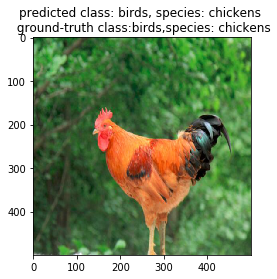

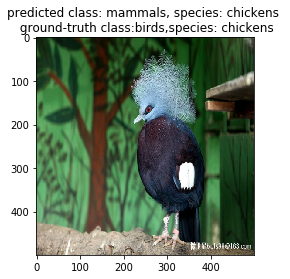

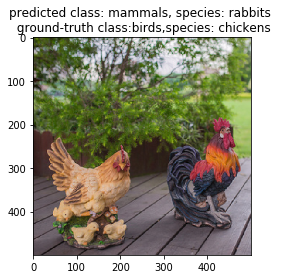

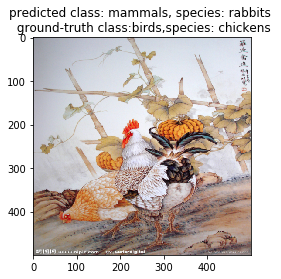

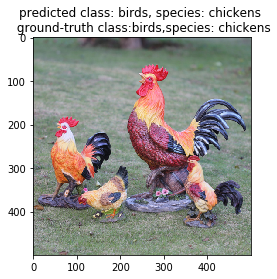

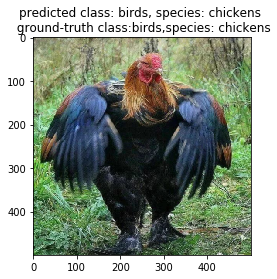

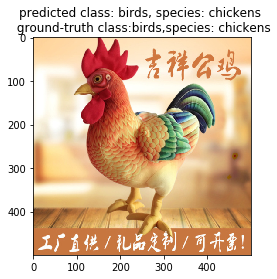

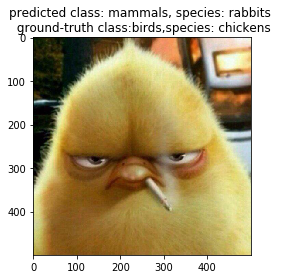

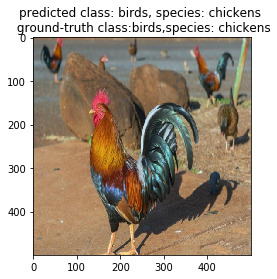

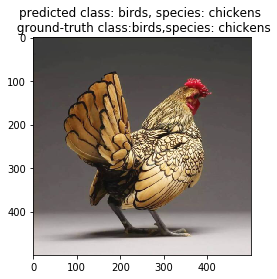

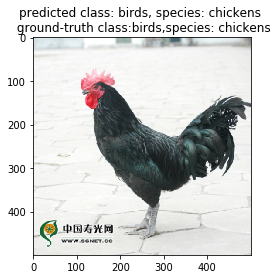

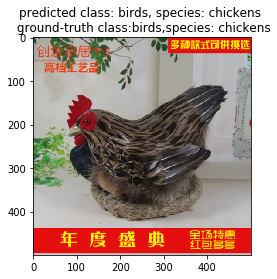

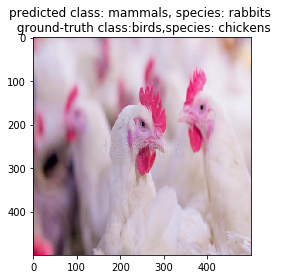

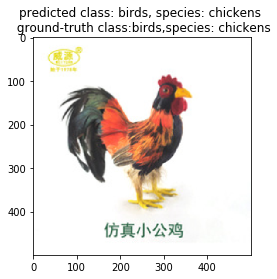

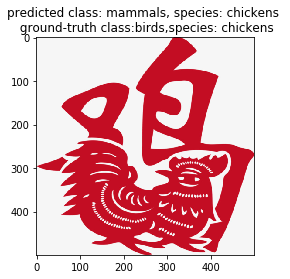

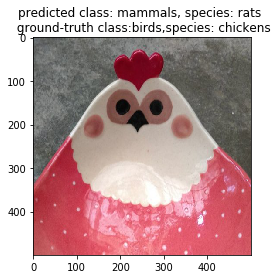

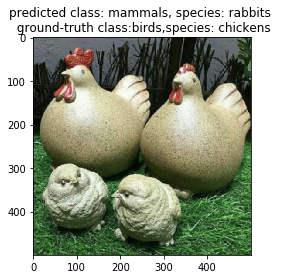

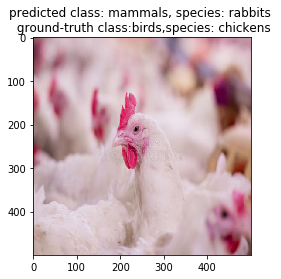

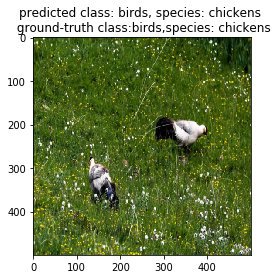

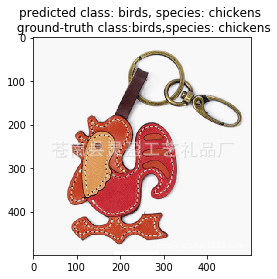

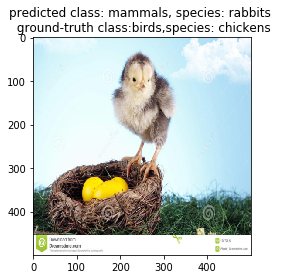

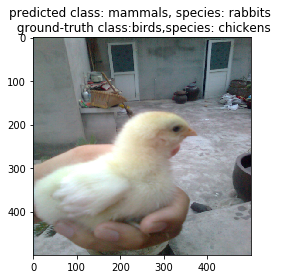

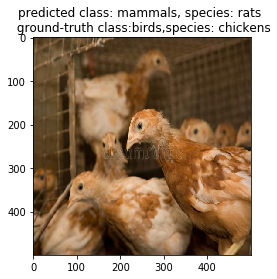

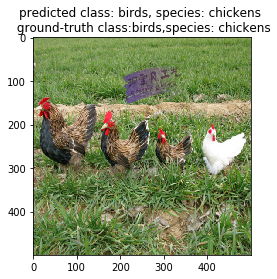

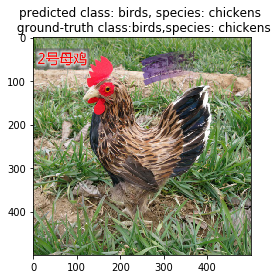

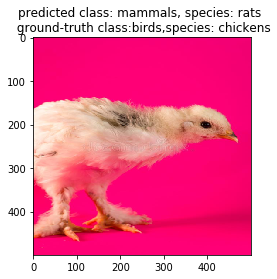

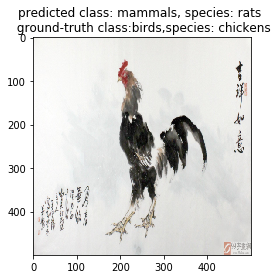

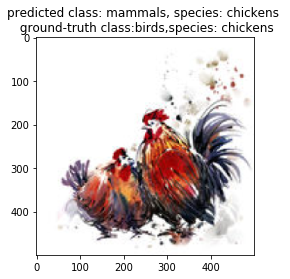

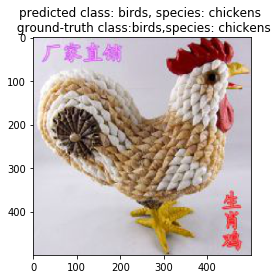

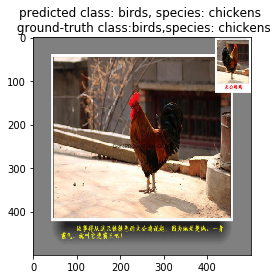

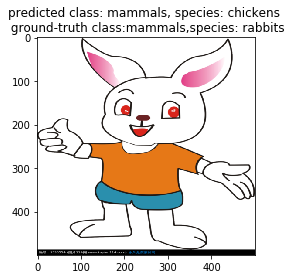

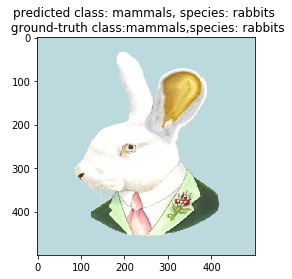

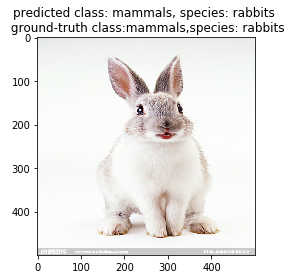

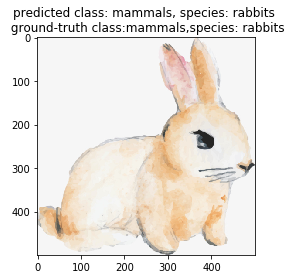

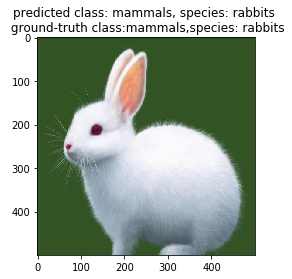

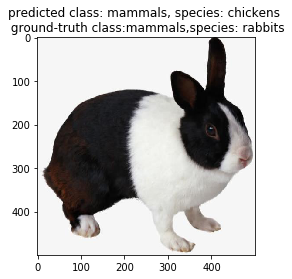

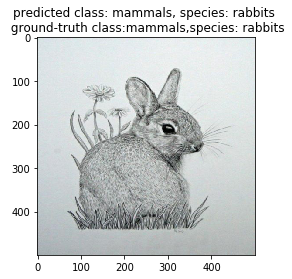

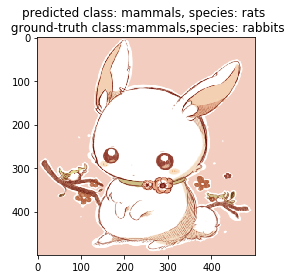

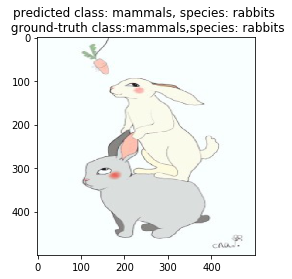

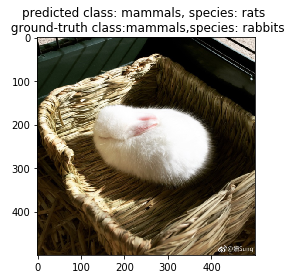

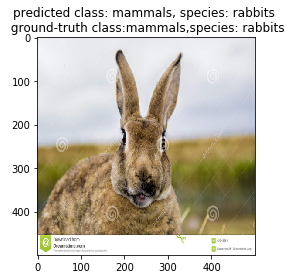

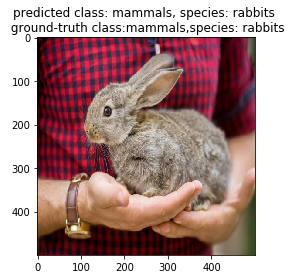

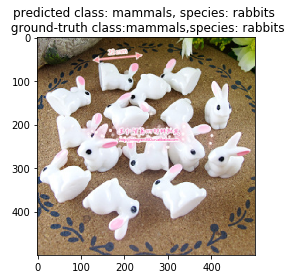

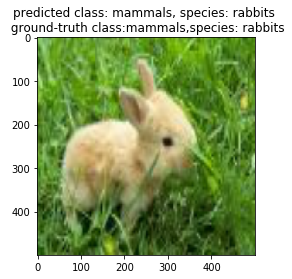

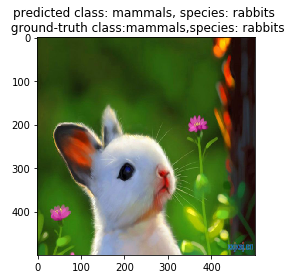

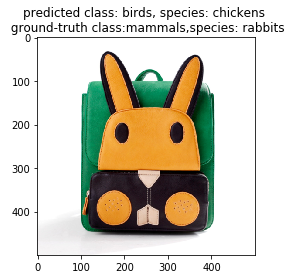

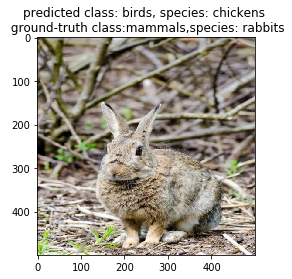

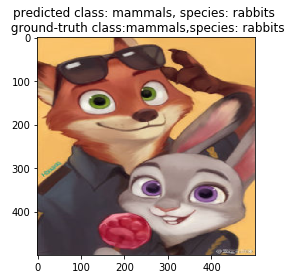

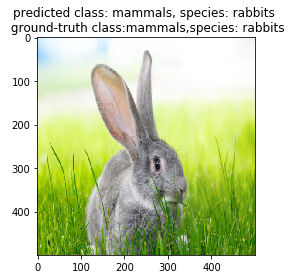

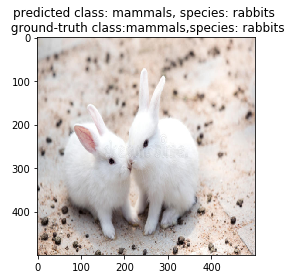

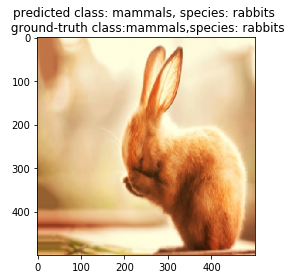

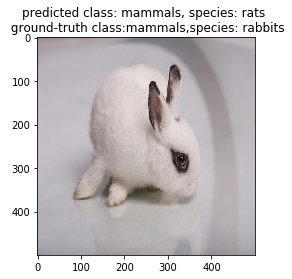

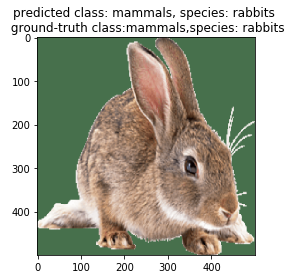

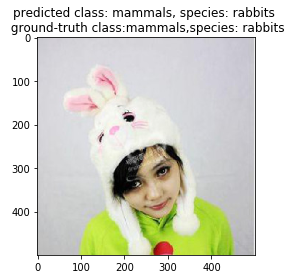

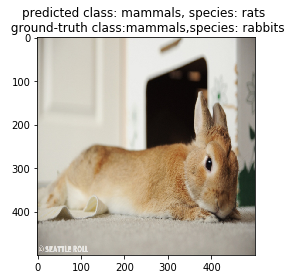

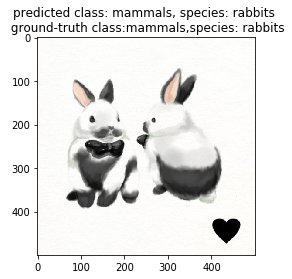

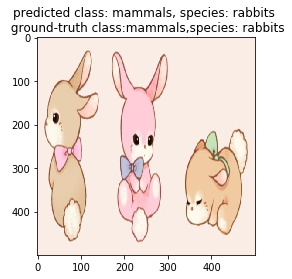

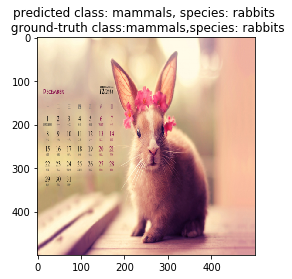

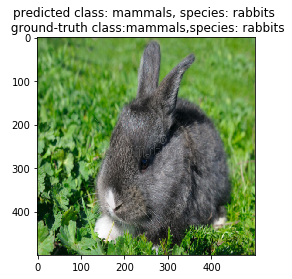

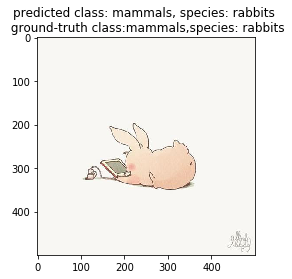

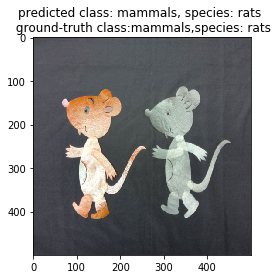

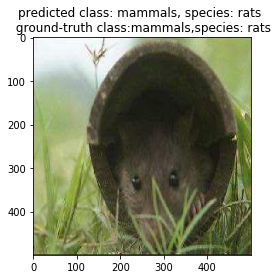

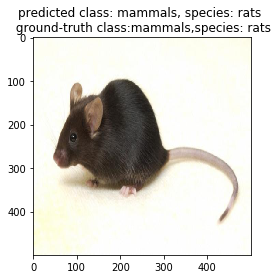

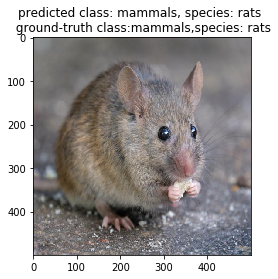

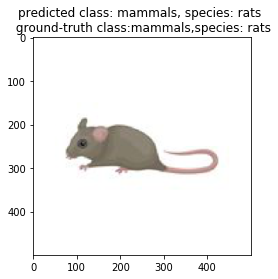

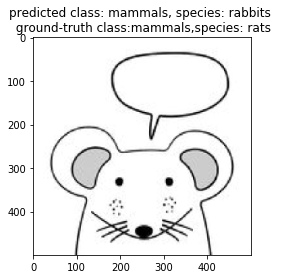

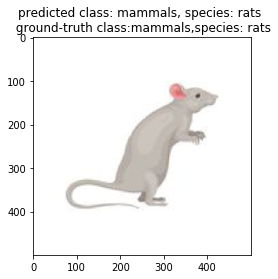

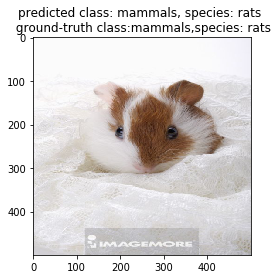

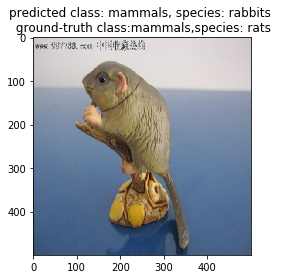

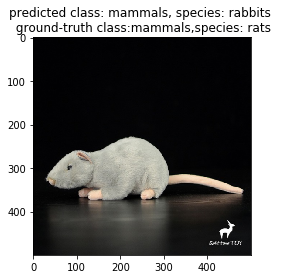

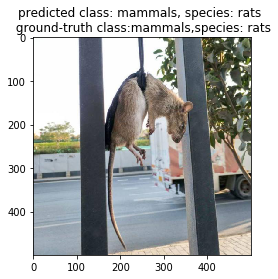

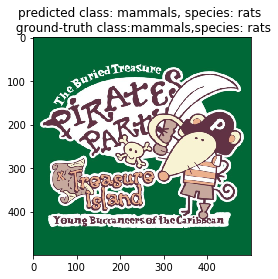

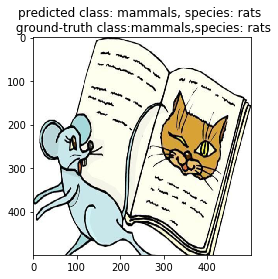

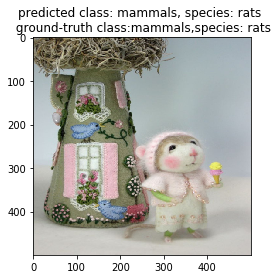

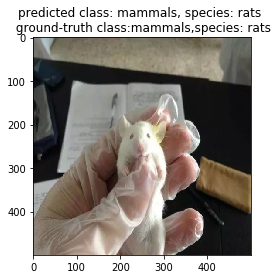

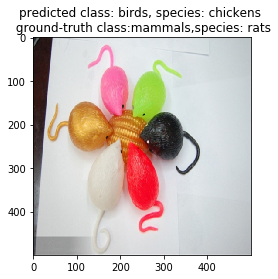

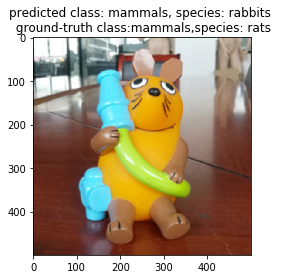

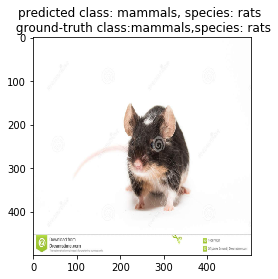

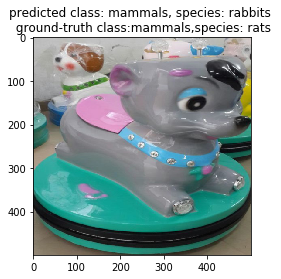

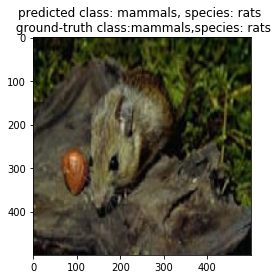

In [313]:
def visualize_model(model):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loaders['val']):
            inputs = data['image']
            labels_classes = data['classes'].to(device)
            labels_species = data['species'].to(device)

            x_classes, x_species = model(inputs.to(device))
            x_classes = x_classes.view(-1, 2)
            x_species = x_species.view(-1, 3)
            _, preds_classes = torch.max(x_classes, 1)
            _, preds_species = torch.max(x_species, 1)

            #print(inputs.shape)
            plt.imshow(transforms.ToPILImage()(inputs.squeeze(0)))
            plt.title('predicted class: {}, species: {} \n ground-truth class:{},species: {}'.format(CLASSES[preds_classes], SPECIES[preds_species], CLASSES[labels_classes], SPECIES[labels_species]))
            plt.show()

visualize_model(model)